# **Trabalho \#1**: Deep Learning MO434/MC934
Universidade Estadual de Campinas (UNICAMP), Instituto de Computação (IC)

Profa. Sandra Avila, 2020s2





In [ ]:
# TODO: RA & Name
print('265673: ' + 'Gabriel Luciano Gomes')
print('225162: ' + 'Victor Juliani Rodrigues')

265673: Gabriel Luciano Gomes
225162: Victor Juliani Rodrigues


## Objetivo

Treinar e explorar o comportamento de diferentes componentes que integram uma **Rede Neural Convolucional (CNN)**, usando um subconjunto do dataset de lesões de pele ISIC Challenge 2017, classificando lesões malignas × benignas.

## Dataset

O dataset ISIC Challenge 2017 contém 2.000 imagens com 3 diagnósticos de lesão: nevos, ceratose seborreica e melanoma. Dessas, apenas melanoma é maligna. 

Para este trabalho vamos considerar apenas a **classificação binária** de malignas × benignas. Utilize o conjunto de validação para avaliar seus experimentos intermediários, e apenas no fim, use o teste. Informações sobre o dataset estão disponíveis em https://challenge.isic-archive.com/landing/2017/44.

A métrica oficial da base de dados é a AUC (_Area Under the ROC Curve_).

## Deadline

Segunda-feira, 7 de Dezembro 14h (antes da aula). 

Política de penalidade para submissões atrasadas: Você não está sendo encorajada(o) a submeter trabalho depois da data de submissão. Entretanto, caso isso aconteça, a nota será penalizada da seguinte forma:
- 8 de Dezembro 14h : nota * 0,75
- 9 de Dezembro 14h : nota * 0,5
- 10 de Dezembro 14h : nota * 0,25


## Submissão

Submeta o Jupyter Notebook (em Português ou Inglês) no Google Classroom.

**O trabalho NÃO é individual, deve ser feito em dupla.**

## Carregamento dos Dados

Os .zips contendo o dataset está no google drive. O código abaixo faz o download, e extrai o zip. Note que você precisará logar no Google para que esse processo seja possível. Caso haja alguma falha ou erro no processo, reinicie o notebook, e tente novamente.

Depois desse processo, teremos no diretório:

*   isic2017-train: 2000 imagens. 
*   isic2017-val:    150 imagens.
*   isic2017-test:   650 imagens.

In [ ]:
!pip install PyDrive &> /dev/null

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1EH2tlRi4Iqq8WfLOXl6hMc5jTeiIRzaW"})
downloaded.GetContentFile('isic2017-trainval.zip')
!unzip -q isic2017-trainval.zip

downloaded = drive.CreateFile({'id':"1uP1tCj6-T2FXxk7g7gqoC_SGOhqIQyrM"})   
downloaded.GetContentFile('isic2017-test.zip')       
!unzip -q isic2017-test.zip



replace isic2017-train/benign/ISIC_0000050.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace isic2017-test/benign/ISIC_0015967.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Em cada diretório, temos uma pasta contendo as lesões benignas ('/benign') e outra contendo as lesões malignas ('/malignant'). A separação dessa forma facilita a importação dos dados utilizando o keras.

Note que o conjunto é altamente desbalanceado. Talvez seja adequado aplicar aumentação de dados nas imagens.

Para aumentação de dados, recomenda-se o uso da ImageDataGenerator do Keras, pois ela facilita o uso de aumentação e pré-processamento dos dados.


Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Formato das imagens de treinamento (256, 256, 3)
Formato das imagens de teste (256, 256, 3)
Formato das imagens de validação (256, 256, 3)


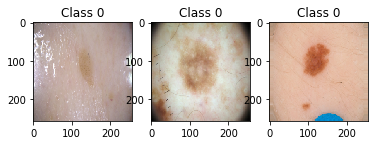

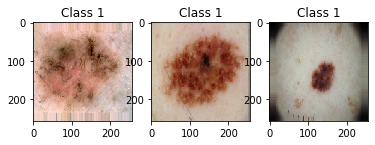

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot

# references:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

generated_train = train_datagen.flow_from_directory(
        'isic2017-train/',
        target_size=(256, 256),
        batch_size=32)

generated_test = test_datagen.flow_from_directory(
        'isic2017-test/',
        target_size=(256, 256),
        batch_size=32)

generated_val = val_datagen.flow_from_directory(
        'isic2017-val/',
        target_size=(256, 256),
        batch_size=32)

print("Formato das imagens de treinamento", generated_train.image_shape) 
print("Formato das imagens de teste", generated_test.image_shape)
print("Formato das imagens de validação", generated_val.image_shape)


batch=generated_train[0] # returns the next batch of images and labels 
for i in range (3):
    pyplot.subplot(1,3,i+1)
    img=batch[0][i]   # this is the first image  batch[0][1] would be the next image
    pyplot.imshow(img, cmap='gray', interpolation='none')    
    pyplot.title("Class {}".format(generated_train.classes[i]))
pyplot.show()  

batch=generated_train[51]
for i in range(3):
    pyplot.subplot(1,3,i+1)
    img=batch[0][i]   # this is the first image  batch[0][1] would be the next image
    pyplot.imshow(img, cmap='gray', interpolation='none')    
    pyplot.title("Class {}".format(generated_train.classes[51*32 + i]))
pyplot.show()  


## Questão 1

1. (1,0) Construa uma rede neural convolucional para baseline. Sugestão: comece por uma arquitetura simples. Quanto mais simples, melhor.


In [ ]:
from tensorflow.keras import layers

n_epochs = 75

model = tf.keras.Sequential([
  layers.Conv2D(10, 3, padding='valid', activation='relu', input_shape=(256,256,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(2, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 10)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 127, 32)      2912      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0

In [ ]:
# Compilação do modelo
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC()])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

unique, counts = np.unique(generated_train.classes, return_counts=True)
print("Treino ---> ", dict(zip(unique, counts)), "\n")

class_weights = compute_class_weight("balanced", np.unique(generated_train.classes), generated_train.classes)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights, "\n")

Treino --->  {0: 1626, 1: 374} 

{0: 0.6150061500615006, 1: 2.6737967914438503} 



In [ ]:
# Treinamento da rede considerando peso de classes
from keras.callbacks import History

history_balanced = History()

history_balanced = model.fit(
        generated_train,
        epochs=n_epochs, 
        batch_size=32,
        class_weight=train_class_weights,
        validation_data=generated_val)

print(history_balanced.history['loss'])

Epoch 1/75
63/63 [==============================] - 31s 490ms/step - loss: 0.6938 - auc: 0.5001 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 2/75
63/63 [==============================] - 31s 489ms/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 3/75
63/63 [==============================] - 31s 489ms/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 4/75
63/63 [==============================] - 31s 492ms/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 5/75
63/63 [==============================] - 31s 491ms/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 6/75
63/63 [==============================] - 31s 490ms/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 7/75
63/63 [==============================] - 31s 491ms/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 8/75
63/63 [==============================] - 31s 494ms/step - 

In [ ]:
# Treinamento da rede desconsiderando o balanceamento da base
history_unbalanced = History()
history_unbalanced = model.fit(
        generated_train,
        epochs=n_epochs, 
        batch_size=32,
        validation_data=generated_val,
        callbacks=[history_unbalanced])

print(history_unbalanced.history['loss'])

Epoch 1/75
63/63 [==============================] - 31s 492ms/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 2/75
63/63 [==============================] - 31s 488ms/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 3/75
63/63 [==============================] - 31s 490ms/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 4/75
63/63 [==============================] - 31s 492ms/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 5/75
63/63 [==============================] - 31s 488ms/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 6/75
63/63 [==============================] - 31s 494ms/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 7/75
63/63 [==============================] - 31s 488ms/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 8/75
63/63 [==============================] - 31s 489ms/step - 

### Impressões



> Quais são as suas impressões? Arquitetura simples demais? Problema difícil demais? Poucos dados? (1-2 parágrafos)




Ao analisar a base de dados, foi observado ela está desbalanceada para a classe de benignos (aproximadamente 3 vezes maior do que a outra classe). Entretanto, ao realizar o balanceamento por peso de classe, tanto o resultado como o loss se manteram iguais. Por sua vez, o balanceamento da base, por peso classes, pode ser descartado para a aplicação. 

Um outro ponto a ser analisado é a arquitetura utilizada; por ser uma arquitetura simples, que obteve acurácia não superior a 50%, não foi capaz de extrair características o suficiente para aumentar a predição. Além disso, o problema em questão possui uma grande dificuldade, pois as características que dividem as classes, em muito dos casos, são quase imperceptíveis. 


## Questão 2


2. (3,0) Explore o impacto de variar a quantidade de camadas de convolução e pooling, funções de ativação, inicializações e regularizações. Cuidado com overfitting! Explore, no mínimo, duas arquiteturas diferentes do baseline.

### Modelo Alternativo 1

In [ ]:
# Modelo Alternativo 1
# Ativação sigmoidal, inicializador RandomNormal
model = tf.keras.Sequential([
  layers.Conv2D(10, 3, padding='valid', activation='sigmoid', input_shape=(256,256,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='sigmoid'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='sigmoid'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(2, activation ='sigmoid', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01), bias_initializer=tf.keras.initializers.Zeros())
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 10)      280       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 10)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 127, 127, 32)      2912      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 61504)            

In [ ]:
# Compilação do modelo
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC()])

# Treinamento do modelo
model_ver_1 = History()
model_ver_1 = model.fit(
        generated_train,
        epochs=n_epochs, 
        batch_size=32,
        validation_data=generated_val,
        callbacks=[model_ver_1])

print(model_ver_1.history['loss'])


Epoch 1/75
63/63 [==============================] - 33s 527ms/step - loss: 0.5971 - auc_1: 0.8154 - val_loss: 0.6032 - val_auc_1: 0.8000
Epoch 2/75
63/63 [==============================] - 33s 522ms/step - loss: 0.5967 - auc_1: 0.8130 - val_loss: 0.6032 - val_auc_1: 0.8000
Epoch 3/75
63/63 [==============================] - 33s 520ms/step - loss: 0.5967 - auc_1: 0.8130 - val_loss: 0.6032 - val_auc_1: 0.8000
Epoch 4/75
63/63 [==============================] - 33s 518ms/step - loss: 0.5967 - auc_1: 0.8130 - val_loss: 0.6032 - val_auc_1: 0.8000
Epoch 5/75
63/63 [==============================] - 33s 518ms/step - loss: 0.5967 - auc_1: 0.8130 - val_loss: 0.6032 - val_auc_1: 0.8000
Epoch 6/75
63/63 [==============================] - 33s 520ms/step - loss: 0.5967 - auc_1: 0.8130 - val_loss: 0.6032 - val_auc_1: 0.8000
Epoch 7/75
63/63 [==============================] - 33s 522ms/step - loss: 0.5967 - auc_1: 0.8130 - val_loss: 0.6032 - val_auc_1: 0.8000
Epoch 8/75
63/63 [=======================

### Modelo Alternativo 2

In [ ]:
# Modelo Alternativo 2
# Adição de camadas de convolução e MaxPooling (16,128,256)
model = tf.keras.Sequential([
  layers.Conv2D(10, 3, padding='valid', activation='relu', input_shape=(256,256,3)),
  layers.MaxPooling2D(),  
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(2, activation='sigmoid')
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 10)      280       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 10)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 127, 127, 16)      1456      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 63, 63, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 31, 31, 64)       

In [ ]:
# Compilação do modelo
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC()])

model_ver_2 = History()
model_ver_2 = model.fit(
        generated_train,
        epochs=n_epochs, 
        batch_size=32,
        validation_data=generated_val,
        callbacks=[model_ver_2])

print(model_ver_2.history['loss'])

Epoch 1/75
63/63 [==============================] - 33s 524ms/step - loss: 0.5986 - auc_2: 0.8130 - val_loss: 0.6032 - val_auc_2: 0.8000
Epoch 2/75
63/63 [==============================] - 33s 522ms/step - loss: 0.5967 - auc_2: 0.8130 - val_loss: 0.6032 - val_auc_2: 0.8000
Epoch 3/75
63/63 [==============================] - 33s 525ms/step - loss: 0.5967 - auc_2: 0.8130 - val_loss: 0.6032 - val_auc_2: 0.8000
Epoch 4/75
63/63 [==============================] - 34s 534ms/step - loss: 0.5967 - auc_2: 0.8130 - val_loss: 0.6032 - val_auc_2: 0.8000
Epoch 5/75
63/63 [==============================] - 33s 523ms/step - loss: 0.5967 - auc_2: 0.8130 - val_loss: 0.6032 - val_auc_2: 0.8000
Epoch 6/75
63/63 [==============================] - 33s 530ms/step - loss: 0.5967 - auc_2: 0.8130 - val_loss: 0.6032 - val_auc_2: 0.8000
Epoch 7/75
63/63 [==============================] - 33s 530ms/step - loss: 0.5967 - auc_2: 0.8130 - val_loss: 0.6032 - val_auc_2: 0.8000
Epoch 8/75
63/63 [=======================

### Modelo Alternativo 3


In [ ]:
# Modelo Alternativo 3
# Alterar Regularizações -> 
# Kernel:
#   A penalidade de regularização L1 é computada por: loss = l1 * reduce_sum(abs(x))
#   A penalidade de regularização L2 é computada por: loss = l2 * reduce_sum(square(x))
# Bias:
#   A penalidade de regularização L2 é computada por: loss = l2 * reduce_sum(square(x))
# Activity:
#   A penalidade de regularização L2 é computada por: loss = l2 * reduce_sum(square(x))

model = tf.keras.Sequential([
  layers.Conv2D(10, 3, padding='valid', activation='relu', input_shape=(256,256,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(
      2,
      activation='sigmoid',
      kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=tf.keras.regularizers.l2(1e-4),
      activity_regularizer=tf.keras.regularizers.l2(1e-5))
])


model.summary()

In [ ]:
# Compilação do modelo
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC()])

model_ver_3 = History()

model_ver_3 = model.fit(
        generated_train,
        epochs=n_epochs, 
        batch_size=32,
        validation_data=generated_val,
        callbacks=[model_ver_3])

print(model_ver_3.history['loss'])

Epoch 1/75
63/63 [==============================] - 34s 537ms/step - loss: 0.6379 - auc_3: 0.8130 - val_loss: 0.6376 - val_auc_3: 0.8000
Epoch 2/75
63/63 [==============================] - 33s 529ms/step - loss: 0.6201 - auc_3: 0.8130 - val_loss: 0.6176 - val_auc_3: 0.8000
Epoch 3/75
63/63 [==============================] - 33s 525ms/step - loss: 0.6065 - auc_3: 0.8130 - val_loss: 0.6095 - val_auc_3: 0.8000
Epoch 4/75
63/63 [==============================] - 33s 525ms/step - loss: 0.6106 - auc_3: 0.7820 - val_loss: 0.6956 - val_auc_3: 0.5000
Epoch 5/75
63/63 [==============================] - 33s 530ms/step - loss: 0.6372 - auc_3: 0.7681 - val_loss: 0.6177 - val_auc_3: 0.8000
Epoch 6/75
63/63 [==============================] - 33s 524ms/step - loss: 0.6013 - auc_3: 0.8130 - val_loss: 0.6043 - val_auc_3: 0.8000
Epoch 7/75
63/63 [==============================] - 33s 523ms/step - loss: 0.7046 - auc_3: 0.7329 - val_loss: 0.7035 - val_auc_3: 0.8000
Epoch 8/75
63/63 [=======================

### Impressões Dos Modelos Analisados

> Quais são as suas impressões? O resultado melhorou em relação ao baseline? (1-2 parágrafos)

Uma primeira impressão é que, ao alterar apenas a inicialização e a função de ativação, diferenças nos resultados obtidos já puderam ser observadas, o que faz todo o sentido do sentido da estrutura da rede neural. Além disso, vemos que ao inserir mais algumas camadas, o número de parâmetros cresce significativamente, mas ainda assim consegue extrair mais informações para a rede. Por fim, ao inserir penalidades de regularização muito severos, foi possível perceber que os resultados pioraram bastante, além de apresentar um alto índice de overfitting.

Quanto ao resultado das redes alternativas, foi possível reduzir e estabilizar o loss em dois dos modelos apresentados. Além disso, pode-se observar uma melhora significativa em relação ao baseline. Um ponto interessante é que em nenhum dos modelos alternativos, obteve-se acurácia superior a 80%, o que se conclui, portanto, a dificuldade da base analisada.


## Questão 3

3. (3,0 pts) Escolha uma arquitetura cuja implementação e pesos pré-treinados na ImageNet estejam disponíveis como extratora de features. 

- (1,5 pts) Inicialmente, descarte a saída original e congele suas as camadas. Adicione uma nova camada de saída com o número de classes adequadas para este problema.


### Descarte de saída original e congelamento de camadas

In [ ]:
# Carregamento do modelo pré-treinado (VGG19) SEM as camadas densas (include_top = False)
model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(256,256,3), classes = 2)

# Congela camadas pré-treinadas
for layer in model.layers:
    layer.trainable = False

model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [ ]:
# Insere novas camadas no fim da rede para classificação
full_model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='sigmoid')
])

full_model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1026      
Total params: 20,025,410
Trainable params: 1,026
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# Instancia um otimizador SGD, compila e treina o modelo completo
sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0.001, nesterov=True)

full_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=sgd, metrics=[tf.keras.metrics.AUC()])

history_frozen_transfer = History()

history_frozen_transfer = full_model.fit(generated_train,
        epochs=n_epochs, 
        batch_size=32,
        validation_data=generated_val,
        callbacks=[history_frozen_transfer])

print(history_frozen_transfer.history['loss'])


Epoch 1/75
63/63 [==============================] - 39s 619ms/step - loss: 0.6520 - auc_4: 0.8116 - val_loss: 0.6217 - val_auc_4: 0.7671
Epoch 2/75
63/63 [==============================] - 37s 590ms/step - loss: 0.6111 - auc_4: 0.8117 - val_loss: 0.6128 - val_auc_4: 0.7635
Epoch 3/75
63/63 [==============================] - 37s 584ms/step - loss: 0.6056 - auc_4: 0.8071 - val_loss: 0.6099 - val_auc_4: 0.7641
Epoch 4/75
63/63 [==============================] - 37s 580ms/step - loss: 0.6033 - auc_4: 0.8121 - val_loss: 0.6085 - val_auc_4: 0.7630
Epoch 5/75
63/63 [==============================] - 37s 585ms/step - loss: 0.6020 - auc_4: 0.8078 - val_loss: 0.6076 - val_auc_4: 0.7618
Epoch 6/75
63/63 [==============================] - 37s 586ms/step - loss: 0.6012 - auc_4: 0.8100 - val_loss: 0.6069 - val_auc_4: 0.7716
Epoch 7/75
63/63 [==============================] - 37s 588ms/step - loss: 0.6006 - auc_4: 0.8101 - val_loss: 0.6065 - val_auc_4: 0.7786
Epoch 8/75
63/63 [=======================

In [ ]:
# Avalia o modelo na validação
score = full_model.evaluate(generated_val, verbose=1)

print('Valid loss:', score[0])
print('Valid acc:', score[1])


5/5 [==============================] - 1s 154ms/step - loss: 0.6039 - auc_4: 0.7920
Valid loss: 0.6039227247238159
Valid acc: 0.7919999957084656


> Quais são as suas impressões? O resultado melhorou em relação à questão anterior? Como foi o tempo de treinamento? Houve overfitting? (1-2 parágrafos) 


### Descongelamento de camadas e Fine-tuning

- (1,5 pts) Descongele as camadas da rede extratora de features e realize o fine-tuning da rede, continuando o treinamento.

In [ ]:
# Carregamento do modelo pré-treinado (VGG19) SEM as camadas densas (include_top = False)
model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(256,256,3), classes=2)

full_model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='sigmoid')
])

for layer in model.layers:
    layer.trainable = True
    
full_model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 20,025,410
Trainable params: 20,025,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compila e treina o modelo
sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
full_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=sgd, metrics=[tf.keras.metrics.AUC()])

history_full_transfer = History()
history_full_transfer = full_model.fit(generated_train,
        epochs=n_epochs, 
        batch_size=32,
        validation_data=generated_val,
        callbacks=[history_full_transfer])

print(history_full_transfer.history['loss'])

In [ ]:
# Avalia o modelo na validação
score = full_model.evaluate(generated_val, verbose=1)

print('Valid loss:', score[0])
print('Valid acc:', score[1])

5/5 [==============================] - 1s 140ms/step - loss: 0.6032 - auc_5: 0.8000
Valid loss: 0.6032047271728516
Valid acc: 0.7999999523162842


### Avaliação dos Modelos

> Quais são as suas impressões? O resultado melhorou em relação à questão anterior? Como foi o tempo de treinamento? Houve overfitting? (1-2 parágrafos)

Os resultados parecem piorar em relação a questão anterior. Por outro lado, apresenta o comportamento de um treinamento mais real, pois apresenta uma curva de aprendizado e não um valor fixo, como observado nos modelos anteriores. Junto a isso, pode-se observar que o valor máximo da acurácia chegou próximo a 80%, o que surpreende ao ser analisado, uma vez que a rede utilizada (VGG19), possui mais de 50 mil vezes mais  parâmetros (20.025.410) do que o modelo alternativo 2 (398,506). O que é um forte indício que o número de parametros não é bom indicador para aumentar a acurácia da predição.

 Um outro fator importante, foi o tempo de treinamento 42% maior do que os outros modelos analisados (47 s por época para o modelo considerando o descongelamento total do transfer, contra 33 s por época do modelo alternativo 2). Por fim, foi possível observar que não houve overfitting para nenhum dos modelos analisados; apesar dos valores de loss serem altos, tanto para a validação quanto o treino, mantiveram uma linha de queda.

## Questão 4

4. (0,5 pts) Plote os gráficos da função de loss × número de épocas, para o treino e validação de cada modelo gerado. Houve overfitting?





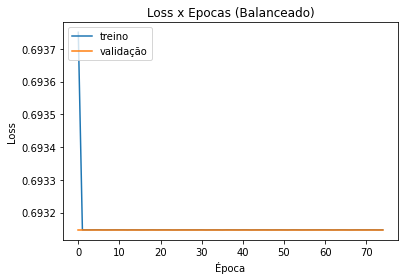

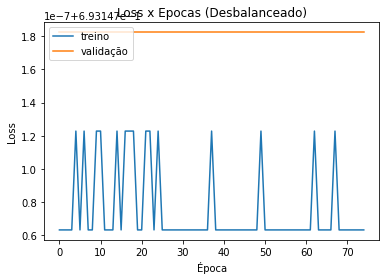

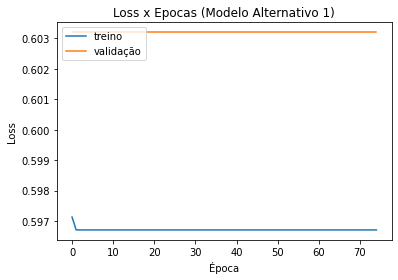

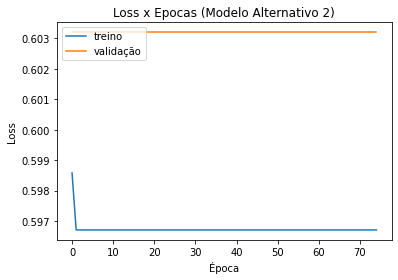

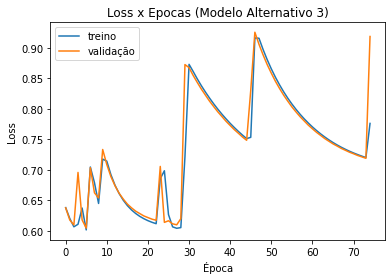

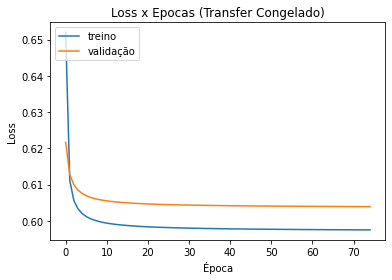

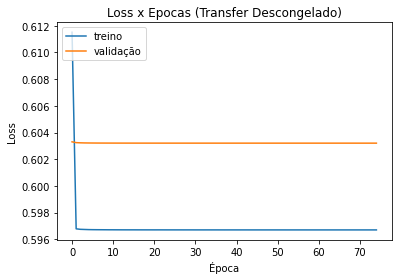

In [ ]:
# TODO
from matplotlib import pyplot

# plot balanceado
pyplot.plot(history_balanced.history['loss'])
pyplot.plot(history_balanced.history['val_loss'])
pyplot.title('Loss x Epocas (Balanceado)')
pyplot.ylabel('Loss')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

# plot desbalanceado
pyplot.plot(history_unbalanced.history['loss'])
pyplot.plot(history_unbalanced.history['val_loss'])
pyplot.title('Loss x Epocas (Desbalanceado)')
pyplot.ylabel('Loss')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

# plot modelo_variacao_1
pyplot.plot(model_ver_1.history['loss'])
pyplot.plot(model_ver_1.history['val_loss'])
pyplot.title('Loss x Epocas (Modelo Alternativo 1)')
pyplot.ylabel('Loss')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

# plot modelo_variacao_2
pyplot.plot(model_ver_2.history['loss'])
pyplot.plot(model_ver_2.history['val_loss'])
pyplot.title('Loss x Epocas (Modelo Alternativo 2)')
pyplot.ylabel('Loss')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

# plot modelo_variacao_3
pyplot.plot(model_ver_3.history['loss'])
pyplot.plot(model_ver_3.history['val_loss'])
pyplot.title('Loss x Epocas (Modelo Alternativo 3)')
pyplot.ylabel('Loss')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

# plot modelo_transfer_congelado
pyplot.plot(history_frozen_transfer.history['loss'])
pyplot.plot(history_frozen_transfer.history['val_loss'])
pyplot.title('Loss x Epocas (Transfer Congelado)')
pyplot.ylabel('Loss')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

# plot modelo_transfer_descongelado
pyplot.plot(history_full_transfer.history['loss'])
pyplot.plot(history_full_transfer.history['val_loss'])
pyplot.title('Loss x Epocas (Transfer Descongelado)')
pyplot.ylabel('Loss')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

### Avaliação das construções

> Quais são as suas impressões? Houve overfitting? (1-2 parágrafos)

Ao realizar a construção dos gráficos, pode-se perceber um comportamento diferente àquele observado apenas pela linha de treinamento das redes. O modelo baseline desbalanceado apresentou uma variação de 'loss' muito instável em relação ao seu treino, além de um 'val_loss' muito superior, aproximando a 2 pontos.

Para os melhores modelos construídos e analisados (modelo alternativo 1, 2 e transfer descongelado), pode-se observar um comportamento estranho no aprendizado, com um valor praticamente fixo no valor loss. Já para os outros modelos, a variação do loss junto a baixa precisão, dá uma ideia mais realística acerca do treinamento.

Outro ponto a ser considerado é o overfitting. Apenas o modelo alternativo 3 apresenta esta caraterística, uma vez que os valores de loss, tanto para o treinamento quanto validação, tiveram variações e crescimento considerável no parâmetro analisado.

## Questão 5

5. (0,5 pts) Avalie o melhor modelo no conjunto de teste. Obs: Avaliação no conjunto de teste só pode ser executada uma única vez.

In [ ]:
# A função predict_classes estima a classe de cada imagem em um conjunto

# Melhor modelo analisado -> Modelo Alternativo 1
predicted_classes = np.argmax(model_ver_1.model.predict(generated_test), axis=-1)


In [ ]:
# Verificação de predições corretas e incorretas
correct_indexes = np.nonzero(predicted_classes == generated_test.classes)[0]
print("Predições corretas:", correct_indexes.shape)
incorrect_indexes = np.nonzero(predicted_classes != generated_test.classes)[0]
print("Predições incorretas:", incorrect_indexes.shape)

Predições corretas: (483,)
Predições incorretas: (117,)


Predições corretas


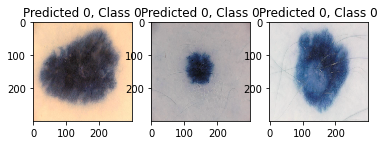

Predições erradas


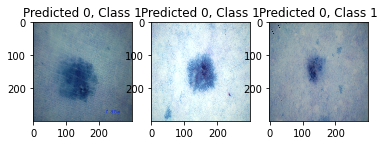

In [ ]:
import cv2 as cv

# Sorteia e plota exemplos corretos e incorretos
print("Predições corretas")
begin = np.random.randint(0, correct_indexes.size-9)
pyplot.figure()


for i, correct in enumerate(correct_indexes[begin:begin+3]):
    pyplot.subplot(1,3,i+1)
    img = cv.imread(generated_train.filepaths[correct_indexes[i]])
    pyplot.imshow(img, cmap='gray', interpolation='none')
    pyplot.title("Predicted {}, Class {}".format(predicted_classes[correct], generated_test.classes[correct]))
pyplot.show()  
    
print("Predições erradas")
begin = np.random.randint(0, incorrect_indexes.size-9)
pyplot.figure()
for i, incorrect in enumerate(incorrect_indexes[begin:begin+3]):
    pyplot.subplot(1,3,i+1)
    img = cv.imread(generated_train.filepaths[incorrect_indexes[i]])
    pyplot.imshow(img, cmap='gray', interpolation='none')
    pyplot.title("Predicted {}, Class {}".format(predicted_classes[incorrect], generated_test.classes[incorrect]))
pyplot.show()

## Questão 6

6. (2,0 pts) Elabore uma conclusão discutindo os experimentos. 

No geral, o trabalho foi esclarecedor em ser um primeiro contato com o Deep Learning, uma tecnologia que nenhum integrante do grupo tinha familiaridade prática. Sendo assim, esse trabalho trouxe alguns desafios, principalmente no que diz respeito a análise da base de dados. Sentimos ser, essa base de dados, uma base bem trabalhosa e não ideal para trabalhar, devido ao número de imagens mas também ao balanceamento. 

Entendendo essas dificuldades, chega-se a conclusão de que a acurácia de 80% foi a maior alcançada pelo grupo, mesmo após aplicar o transfer learning. Um outro fator importante a ser considerado, foi o número de épocas utilizado para o treinamento. Para este trabalho, foram analisadas a variação de 10, 20, 25, 30 e 100 épocas, porém todas elas apresentaram os mesmos valores, para todos os modelos construídos nesta análise.

Nesse contexto, vale ressaltar essa insistência da acurácia que tangencia os 80%. O que levou a pontos de discussão interessantes no grupo sobre o que poderia estar causando esse comportamento, bem como quais parâmetros poderiam ser alterados para aumentar este valor. Por fim, em um dos testes realizados,  o modelo de transfer learning apresentou acurácia de 83% nos testes considerando 30 épocas, porém apresentou alto overfitting (loss de teste próximo aos 0.25 e loss de validação próximo de 0.85). 

Concluindo, nesta análise foi explorado a variação dos modelos em diversos pontos, porém não apresentou variações consideravelmente favoráveis. Dito isso, neste estudo a base analisada teve dificuldade elevada no quesito de extração de características. Junto a isso, uma outra abordagem a ser analisada seria uma nova validação dos modelos construídos alterando a base em diversos outros aspectos, como o balanceamento por número de amostras, aumentação (geração de imagens), reescalonamento, identificação e redução de ruídos e até mesmo explorar outras bases que possam contribuir para o treinamento das redes aqui analisadas. 
